In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/MyDrive/DLMI_challenge')

Mounted at /content/drive


In [2]:
!pip install torchmetrics pytorch_optimizer torchstain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import h5py
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchmetrics
import timm
import pytorch_optimizer

from copy import deepcopy
from itertools import cycle

from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

%matplotlib inline

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() # for Nvidia GPU users
                      else 'mps' if torch.backends.mps.is_available() # for MacOS MPS users
                      else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
DATA_PATH = "data/precomputed_data/"
TEST_IMAGES_PATH = "data/test.h5"
TRAIN_IMAGES_PATH = "data/train.h5"
SEED = 0

In [6]:
torch.random.manual_seed(SEED)
random.seed(SEED)

In [7]:
from src.preprocessing import StainNormalize

import torchvision.transforms.functional as TF
from torchvision.transforms import v2
from torch.utils.data import random_split

preprocessing = T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

with h5py.File(TRAIN_IMAGES_PATH, 'r') as hdf:
    records = []
    for img_idx in hdf.keys():
        label = int(np.array(hdf.get(img_idx).get('label')))
        center = int(np.array(hdf.get(img_idx).get('metadata'))[0])

        records.append({'index': img_idx, 'center': center, 'label': label})

train_dataframe = pd.DataFrame(records) # We store the idx of each img with metadatas.

# We choose a target image to fit the stain normalizer
# This image will be used to normalize all other images in the dataset
target_idx = train_dataframe[train_dataframe['center'] == 3].sample(1, random_state=SEED+15)['index'].values[0]

# Open the HDF5 file in read mode
hdf = h5py.File(TRAIN_IMAGES_PATH, 'r', swmr=True)

# Define the transform for the target image to matches the input size of the model
target_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Read the target image from the HDF5 file, apply the transform and multiply the image by 255.0
target_img = torch.from_numpy(hdf[target_idx]['img'][()]).float()
target_img = target_transform(target_img)*255.0

# Setup the stain normalizer with the target image
stain_normalizer = StainNormalize(target_image_tensor=target_img, backend='torch', method='reinhard')

stain_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    stain_normalizer
])

# DLMI CHALLENGE : Model definition and Training

In this notebook, we build upon the preprocessing strategy defined in `data_analysis.ipynb` and `data_preparation.ipynb` notebook. Our objective is to mitigate the influence of center-specific variations in the classification of infected tissues. We aim to achieve this by combining robust preprocessing with a well-designed training pipeline, allowing the model to focus on biologically meaningful features rather than artifacts related to data acquisition.

In [8]:
class PrecomputedDataset(Dataset):
    def __init__(self, features, labels, centers):
        super(PrecomputedDataset, self).__init__()
        self.features = features
        self.labels = labels.unsqueeze(-1)
        self.centers = centers

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx].float(), self.centers[idx].float()

def load_precomputed_dataset(filename):
    """Load a PrecomputedDataset from a HDF5 file.
    Args :
    filename : file path
    """
    with h5py.File(filename, 'r') as h5f:
        features = torch.tensor(h5f['features'][:])
        labels = torch.tensor(h5f['labels'][:])
        centers = torch.tensor(h5f['centers'][:])
    return PrecomputedDataset(features, labels,centers)


## Full backbone + linear probing

For the first model we define it as a pre-trained backbone and a trainable linear classifier. To do so we use the `train_owk_full_backbone.h5` dataset that contain the inference of the pretrained viT model used as a backbone.

In [ ]:
##### Definition of Training parameters #####
STAIN = False

OPTIMIZER = 'Nero'
OPTIMIZER_PARAMS = {'lr': 0.001}
LOSS = 'BCELoss'
METRIC = 'Accuracy'

EPOCHS = 30
PATIENCE = 10
VAL_EPOCHS = 1 # Number of epochs between each validation pass
PLOT = True # Plot the training and validation loss

BATCH_SIZE = 32

##### Definition of the training and validation datasets #####

if STAIN:
    METHOD = 'owk_stain_full_backbone_linear_prob'
    pretrain_dataset = load_precomputed_dataset('data/precomputed_datasets/train_owk_stain_full_backbone.h5')
    preval_dataset = load_precomputed_dataset('data/precomputed_datasets/val_owk_stain_full_backbone.h5')
else:
    METHOD = 'owk_full_backbone_linear_prob'
    pretrain_dataset = load_precomputed_dataset('data/precomputed_datasets/train_owk_full_backbone.h5')
    preval_dataset = load_precomputed_dataset('data/precomputed_datasets/val_owk_full_backbone.h5')

pretrain_loader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)
preval_loader = DataLoader(preval_dataset, batch_size=BATCH_SIZE, shuffle=False)

##### Definition of the classification head #####

linear_probing = torch.nn.Sequential(nn.Linear(384, 100), nn.ReLU(),nn.Linear(100,1),
                                     nn.Sigmoid()).to(device)

##### Definition of training function #####

optimizer = getattr(pytorch_optimizer, OPTIMIZER)(linear_probing.parameters(), **OPTIMIZER_PARAMS)
criterion = getattr(nn, LOSS)(reduction = 'sum')
metric = getattr(torchmetrics, METRIC)('binary')
min_loss, best_epoch = float('inf'), 0

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 1 with accuracy 0.9653 and loss 0.1014


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 2 with accuracy 0.9691 and loss 0.0895


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 3 with accuracy 0.9708 and loss 0.0834


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 4 with accuracy 0.9717 and loss 0.0809


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 5 with accuracy 0.9725 and loss 0.0792


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 9 with accuracy 0.9729 and loss 0.0766


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 10 with accuracy 0.9730 and loss 0.0759


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 11 with accuracy 0.9733 and loss 0.0755


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 16 with accuracy 0.9737 and loss 0.0760


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Early stopping at epoch 26


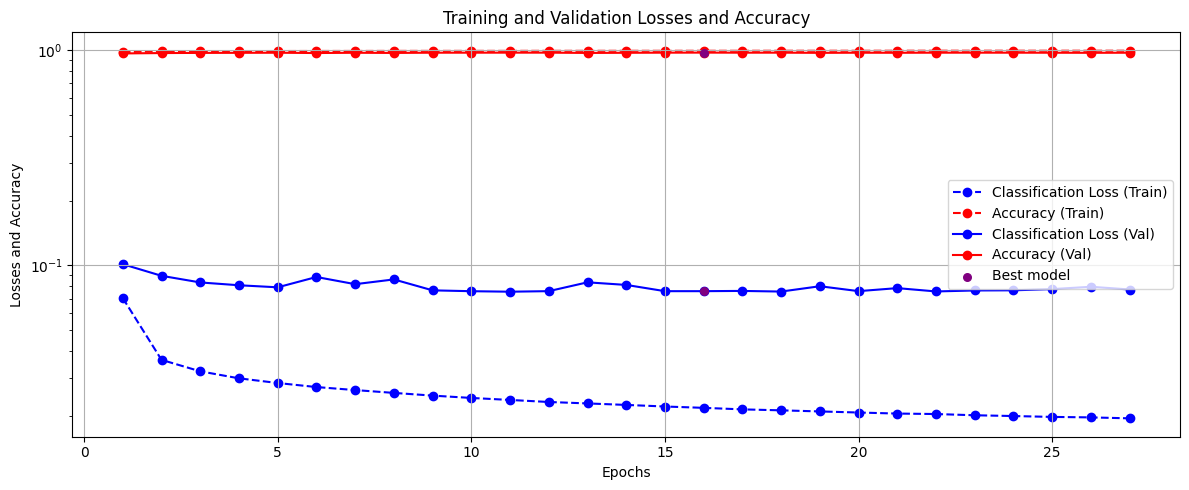

In [ ]:
best_linear_probing = None
best_train_loss = float('inf')
best_val_loss = float('inf')
best_val_acc = 0
best_epoch = 0

training_losses = []
training_metric = []
training_epochs = []

validation_losses = []
validation_metric = []
validation_epochs = []

desc = "{} : {} / {} epochs - Loss : {:.4f} | Accuracy : {:.4f}"

for epoch in range(EPOCHS):

    linear_probing.train()
    current_num_data = 0
    train_loss = 0

    MODE = 'TRAINING'

    train_tqdm = tqdm(pretrain_loader, unit='batch')

    for i, (imgs, labels, _) in enumerate(train_tqdm):

        imgs = imgs.to(device)
        labels = labels.squeeze().to(device)

        pred = linear_probing(imgs).squeeze()
        loss = criterion(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        current_num_data += len(labels)

        pred_labels = (pred > 0.5).float()
        acc = metric(pred_labels.cpu(), labels.cpu())

        train_tqdm.set_description(desc.format(MODE, epoch+1, EPOCHS, train_loss/current_num_data, metric.compute().item()))

    training_losses.append(train_loss/current_num_data)
    training_metric.append(metric.compute().item())
    training_epochs.append(epoch+1)
    metric.reset()

    torch.save(linear_probing.state_dict(), f'model/{METHOD}.pth')

    if (epoch + 1) % VAL_EPOCHS == 0:

        linear_probing.eval()
        current_num_data = 0
        val_loss = 0

        MODE = 'VALIDATION'

        val_tqdm = tqdm(preval_loader, unit='batch')

        for i, (imgs, labels, _) in enumerate(val_tqdm):

            imgs = imgs.to(device)
            labels = labels.squeeze().to(device)

            with torch.no_grad():
                pred = linear_probing(imgs).squeeze()
                loss = criterion(pred, labels)

            val_loss += loss.item()
            current_num_data += len(labels)

            pred_labels = (pred > 0.5).float()
            acc = metric(pred_labels.cpu(), labels.cpu())

            val_tqdm.set_description(desc.format(MODE, (epoch+1)//VAL_EPOCHS, EPOCHS//VAL_EPOCHS, val_loss/current_num_data, metric.compute().item()))

        validation_losses.append(val_loss/current_num_data)
        validation_metric.append(metric.compute().item())
        validation_epochs.append(epoch+1)
        metric.reset()

        if validation_metric[-1] > best_val_acc:
            best_linear_probing = deepcopy(linear_probing)
            best_train_loss = training_losses[-1]
            best_val_loss = validation_losses[-1]
            best_epoch = epoch +1
            best_val_acc = validation_metric[-1]
            print(f"Best model updated at epoch {epoch+1} with accuracy {best_val_acc:.4f} and loss {best_val_loss:.4f}")
            torch.save(best_linear_probing.state_dict(), f'model/best_{METHOD}.pth')

    if epoch - (best_epoch-1) > PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break

if PLOT:
    plt.figure(figsize=(12, 5))
    # Plot Training
    plt.plot(training_epochs, training_losses, label='Classification Loss (Train)', color = 'blue', linestyle = '--', marker = 'o', zorder = 1)
    plt.plot(training_epochs, training_metric, label='Accuracy (Train)', color = 'red', linestyle = '--', marker = 'o', zorder = 1)

    if len(validation_epochs) > 0:
        # Plot Validation
        plt.plot(validation_epochs, validation_losses, label='Classification Loss (Val)', color = 'blue', linestyle = '-', marker = 'o', zorder = 1)
        plt.plot(validation_epochs, validation_metric, label='Accuracy (Val)', color = 'red', linestyle = '-', marker = 'o', zorder = 1)
        plt.scatter(best_epoch, best_val_acc, label = 'Best model', color = 'purple', marker = 'o', s = 30, zorder = 3)
        plt.scatter(best_epoch, best_val_loss, color = 'purple', marker = 'o', s = 30, zorder = 3)

    plt.title('Training and Validation Losses and Accuracy')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Losses and Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"imgs/{METHOD}.png")

    plt.show()

### Froward pass on the testing set

In [ ]:
STAIN = False
MODEL = 'best_okw_full_backbone_linear_prob'

# Loading our feature extractor
backbone = timm.create_model(
  model_name="hf-hub:1aurent/vit_base_patch16_224.owkin_pancancer",
  pretrained=True,
  num_classes = 384
)
backbone.head.load_state_dict(torch.load('data/precomputed_datasets/'+('owk_backbone_head_stain.pth' if STAIN
                                                                       else 'owk_backbone_head.pth')))
backbone.eval().to(device)

# Loading our head
linear_probing_test = torch.nn.Sequential(nn.Linear(384, 100), nn.ReLU(),nn.Linear(100,1),
                                     nn.Sigmoid()).to(device)

linear_probing_test.load_state_dict(torch.load(f'model/{MODEL}.pth'))
linear_probing_test.eval().to(device)

# # Forward pass on the test dataset
# solutions_data = {'ID' : [], 'Pred' : []}
# with h5py.File(TEST_IMAGES_PATH, 'r') as h5f:
#     test_ids = list(h5f.keys())
#     for test_id in tqdm(test_ids):
#         img = torch.from_numpy(h5f[test_id]['img'][()]).float()
#         if STAIN:
#             img = stain_transform(img).unsqueeze(0).to(device)
#         else:
#             img = preprocessing(img).unsqueeze(0).to(device)
#         with torch.no_grad():
#             pred = linear_probing_test(backbone(img)).detach().cpu()
#         solutions_data['ID'].append(int(test_id))
#         solutions_data['Pred'].append(int(pred.item() > 0.5))
# solutions_data = pd.DataFrame(solutions_data).set_index('ID')
# solutions_data.to_csv(f'prediction/{MODEL}.csv')

  0%|          | 0/85054 [00:00<?, ?it/s]

## Backbone without head + Linear probing

Since the previous model yielded good results, we will further fine-tune it. As the head of the pre-trained backbone is not pre-trained, we will train it alongside the backbone using a linear probing approach.

In [42]:
STAIN = False

OPTIMIZER = 'Nero'
OPTIMIZER_PARAMS = {'lr': 0.001, 'weight_decay': 1e-4}
LOSS = 'BCEWithLogitsLoss'
METRIC = 'Accuracy'

EPOCHS = 30
PATIENCE = 8
VAL_EPOCHS = 1 # Number of epochs between each validation
PLOT = True # Plot the training and validation loss

BATCH_SIZE = 32

if STAIN:
    METHOD = 'okw_stain_backbone_without_head_linear_prob'
    pretrain_dataset = load_precomputed_dataset('data/precomputed_datasets/train_owk_stain_backbone_without_head.h5')
    preval_dataset = load_precomputed_dataset('data/precomputed_datasets/val_owk_stain_backbone_without_head.h5')
else:
    METHOD = 'okw_backbone_without_head_linear_prob'
    pretrain_dataset = load_precomputed_dataset('data/precomputed_datasets/train_owk_backbone_without_head.h5')
    preval_dataset = load_precomputed_dataset('data/precomputed_datasets/val_owk_backbone_without_head.h5')

pretrain_loader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)
preval_loader = DataLoader(preval_dataset, batch_size=BATCH_SIZE, shuffle=False)

linear_probing = torch.nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 1)
).to(device)

optimizer = getattr(pytorch_optimizer, OPTIMIZER)(linear_probing.parameters(), **OPTIMIZER_PARAMS)
criterion = getattr(nn, LOSS)(reduction = 'sum')
metric = getattr(torchmetrics, METRIC)('binary')
min_loss, best_epoch = float('inf'), 0

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 1 with accuracy 0.9696 and loss 0.0840


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 2 with accuracy 0.9709 and loss 0.0789


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 3 with accuracy 0.9723 and loss 0.0767


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 4 with accuracy 0.9724 and loss 0.0759


  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/3125 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Early stopping at epoch 12


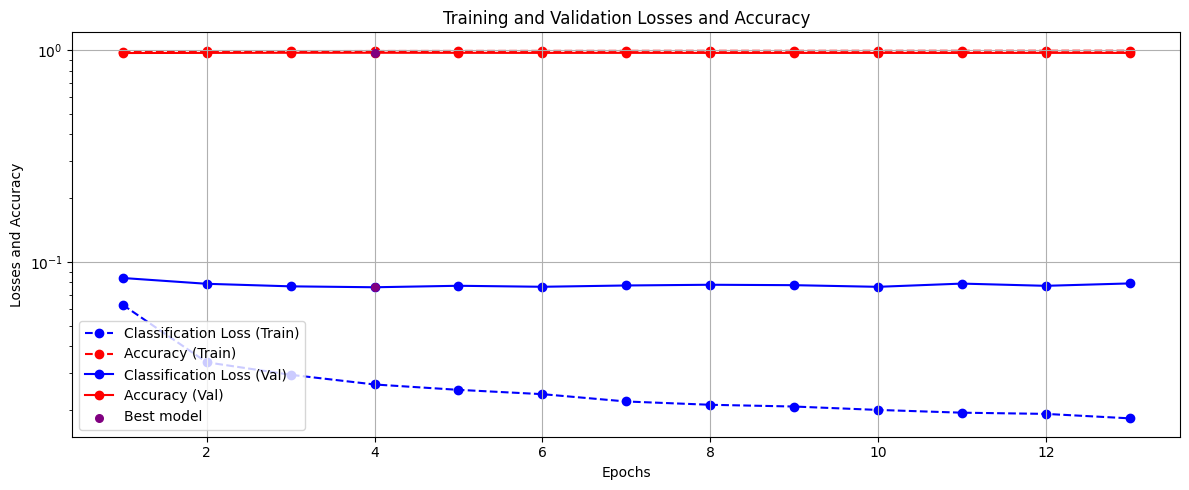

In [43]:
best_linear_probing = None
best_train_loss = float('inf')
best_val_loss = float('inf')
best_val_acc = 0
best_epoch = 0

training_losses = []
training_metric = []
training_epochs = []

validation_losses = []
validation_metric = []
validation_epochs = []

desc = "{} : {} / {} epochs - Loss : {:.4f} | Accuracy : {:.4f}"

for epoch in range(EPOCHS):

    linear_probing.train()
    current_num_data = 0
    train_loss = 0

    MODE = 'TRAINING'

    train_tqdm = tqdm(pretrain_loader, unit='batch')

    for i, (imgs, labels, _) in enumerate(train_tqdm):

        imgs = imgs.to(device)
        labels = labels.squeeze().to(device)

        pred = linear_probing(imgs).squeeze()
        loss = criterion(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        current_num_data += len(labels)

        pred_labels = (torch.sigmoid(pred) > 0.5).float()
        acc = metric(pred_labels.cpu(), labels.cpu())

        train_tqdm.set_description(desc.format(MODE, epoch+1, EPOCHS, train_loss/current_num_data, metric.compute().item()))

    training_losses.append(train_loss/current_num_data)
    training_metric.append(metric.compute().item())
    training_epochs.append(epoch+1)
    metric.reset()

    torch.save(linear_probing.state_dict(), f'model/{METHOD}.pth')

    if (epoch + 1) % VAL_EPOCHS == 0:

        linear_probing.eval()
        current_num_data = 0
        val_loss = 0

        MODE = 'VALIDATION'

        val_tqdm = tqdm(preval_loader, unit='batch')

        for i, (imgs, labels, _) in enumerate(val_tqdm):

            imgs = imgs.to(device)
            labels = labels.squeeze().to(device)

            with torch.no_grad():
                pred = linear_probing(imgs).squeeze()
                loss = criterion(pred, labels)

            val_loss += loss.item()
            current_num_data += len(labels)

            pred_labels = (torch.sigmoid(pred) > 0.5).float()
            acc = metric(pred_labels.cpu(), labels.cpu())

            val_tqdm.set_description(desc.format(MODE, (epoch+1)//VAL_EPOCHS, EPOCHS//VAL_EPOCHS, val_loss/current_num_data, metric.compute().item()))

        validation_losses.append(val_loss/current_num_data)
        validation_metric.append(metric.compute().item())
        validation_epochs.append(epoch+1)
        metric.reset()

        if validation_metric[-1] > best_val_acc:
            best_linear_probing = deepcopy(linear_probing)
            best_train_loss = training_losses[-1]
            best_val_loss = validation_losses[-1]
            best_epoch = epoch +1
            best_val_acc = validation_metric[-1]
            print(f"Best model updated at epoch {epoch+1} with accuracy {best_val_acc:.4f} and loss {best_val_loss:.4f}")
            torch.save(best_linear_probing.state_dict(), f'model/best_{METHOD}.pth')

    if epoch - (best_epoch-1) > PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break

if PLOT:
    plt.figure(figsize=(12, 5))
    # Plot Training
    plt.plot(training_epochs, training_losses, label='Classification Loss (Train)', color = 'blue', linestyle = '--', marker = 'o', zorder = 1)
    plt.plot(training_epochs, training_metric, label='Accuracy (Train)', color = 'red', linestyle = '--', marker = 'o', zorder = 1)

    if len(validation_epochs) > 0:
        # Plot Validation
        plt.plot(validation_epochs, validation_losses, label='Classification Loss (Val)', color = 'blue', linestyle = '-', marker = 'o', zorder = 1)
        plt.plot(validation_epochs, validation_metric, label='Accuracy (Val)', color = 'red', linestyle = '-', marker = 'o', zorder = 1)
        plt.scatter(best_epoch, best_val_acc, label = 'Best model', color = 'purple', marker = 'o', s = 30, zorder = 3)
        plt.scatter(best_epoch, best_val_loss, color = 'purple', marker = 'o', s = 30, zorder = 3)

    plt.title('Training and Validation Losses and Accuracy')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Losses and Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"imgs/{METHOD}.png")

    plt.show()

### Froward pass on the testing set

In [47]:
STAIN = False
MODEL = 'best_okw_backbone_without_head_linear_prob'

# Loading our feature extractor
backbone = timm.create_model(
  model_name="hf-hub:1aurent/vit_base_patch16_224.owkin_pancancer",
  pretrained=True
)
backbone.eval().to(device)

# Loading our head
linear_probing_test =torch.nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 1)
).to(device)

linear_probing_test.load_state_dict(torch.load(f'model/{MODEL}.pth'))
linear_probing_test.eval().to(device)

# Forward pass on the test dataset
solutions_data = {'ID' : [], 'Pred' : []}
with h5py.File(TEST_IMAGES_PATH, 'r') as h5f:
    test_ids = list(h5f.keys())
    for test_id in tqdm(test_ids):
        img = torch.from_numpy(h5f[test_id]['img'][()]).float()
        if STAIN:
            img = stain_transform(img).unsqueeze(0).to(device)
        else:
            img = preprocessing(img).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = linear_probing_test(backbone(img)).detach().cpu()
        solutions_data['ID'].append(int(test_id))
        solutions_data['Pred'].append(int(torch.sigmoid(pred).item() > 0.5))
solutions_data = pd.DataFrame(solutions_data).set_index('ID')
solutions_data.to_csv(f'prediction/{MODEL}.csv')

  0%|          | 0/85054 [00:00<?, ?it/s]

## Domain Adaptation Method

As observed earlier, our model, without additional fine-tuning, tends to overfit the training data. This overfitting may stem from a shift in data distribution, possibly due to differences in centers, leading to domain variation between the validation and test sets. To address this issue and improve the model's generalization, we will now implement and evaluate a domain adaptation technique aimed at enhancing the model's understanding of the task.

### Definition of the `feature_exctractor`, the `domain_classifier` and the `classifier`

In [48]:
from torch.autograd import Function

In [134]:
# The domain_classifier consists in a gradient reversal layer
# and a simple feedforward neural network
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [152]:
# classifier = ProbabilisticClassifier(hidden_size=100)

# classifier = nn.Sequential(nn.Linear(384, 100), nn.ReLU(),
#                            nn.Linear(100, 1))

# domain_classifier = nn.Sequential(
#     GradientReversal(),
#     nn.Linear(384, 100),
#     nn.ReLU(),
#     nn.Linear(100, 3), # 3 domain in the training set
# )

features_extractor = nn.Sequential(
    nn.LayerNorm(768, eps = 1e-06, elementwise_affine=True),
    nn.Linear(768, 384),  nn.ReLU()
)

classifier = nn.Sequential(
    nn.Linear(384, 100),
    nn.Dropout(0.4),
    nn.ReLU(),
    nn.Linear(100, 1)
)

domain_classifier = nn.Sequential(
    GradientReversal(),
    nn.Linear(384, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 3), # 3 domain in the training set
)

features_extractor.to(device)
classifier.to(device)
domain_classifier.to(device)

Sequential(
  (0): GradientReversal()
  (1): Linear(in_features=384, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=3, bias=True)
)

In [153]:
BATCH_SIZE = 32
STAIN = False
EPOCHS = 20
VAL_EPOCHS = 1 # Number of epochs between each validation
ALPHA = 0.5 # Weight of the training loss ALPHA*classification_criterion + (1-ALPHA)*domain_criterion
PLOT = True # Plot the training and validation loss
PATIENCE = 10
smooth_eps = 0.2

# definition of the training parameters and functions
domain_counts = {0: 0.17, 3: 0.38, 4: 0.45}
weights = [1.0 / class_count for class_count in domain_counts.values()]
domain_weights = torch.tensor(weights, dtype = torch.float32).to(device)
domain_weights = domain_weights / domain_weights.sum() # Normalize the weights

center_to_index = {0: 0, 3: 1, 4: 2} # to exctract the class from the domain_classifier output
domain_criterion = nn.CrossEntropyLoss(weight=domain_weights, reduction = 'sum')

# classification_criterion = nn.CrossEntropyLoss(reduction = 'sum')
classification_criterion = nn.BCEWithLogitsLoss(reduction = 'sum')
metric = torchmetrics.Accuracy('binary').to(device)

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-5

optimizer_f = torch.optim.AdamW(features_extractor.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer_c = torch.optim.AdamW(classifier.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer_d = torch.optim.AdamW(domain_classifier.parameters(), lr=1e-6, weight_decay=WEIGHT_DECAY)


if STAIN:
    METHOD = 'owk_backbone_domain_adaptated_stained'
    pretrain_dataset = load_precomputed_dataset('data/precomputed_datasets/train_owk_stain_backbone_without_head.h5')
    preval_dataset = load_precomputed_dataset('data/precomputed_datasets/val_owk_stain_backbone_without_head.h5')
else:
    METHOD = 'owk_backbone_domain_adaptated'
    pretrain_dataset = load_precomputed_dataset('data/precomputed_datasets/train_owk_backbone_without_head.h5')
    preval_dataset = load_precomputed_dataset('data/precomputed_datasets/val_owk_backbone_without_head.h5')


# Construction of the source and target datasets
dataset_size = len(pretrain_dataset)
indices = np.random.permutation(dataset_size)
split = int(0.9 * dataset_size)
source_idx, target_idx = indices[:split], indices[split:]

source_dataset = Subset(pretrain_dataset, source_idx)
target_dataset = Subset(pretrain_dataset, target_idx)

source_loader = DataLoader(source_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           pin_memory=True)

target_loader = DataLoader(target_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           pin_memory=True)

# We also define the train, validation and test dataloaders
# the train dataloader will be used after some epochs to train the full model on all training data
pretrain_loader = DataLoader(
    pretrain_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

preval_loader = DataLoader(
    preval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Best model updated at epoch 1 with accuracy 0.9732 and loss 0.1920


  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

  0%|          | 0/2813 [00:00<?, ?batch/s]

  0%|          | 0/1091 [00:00<?, ?batch/s]

Early stopping at epoch 11


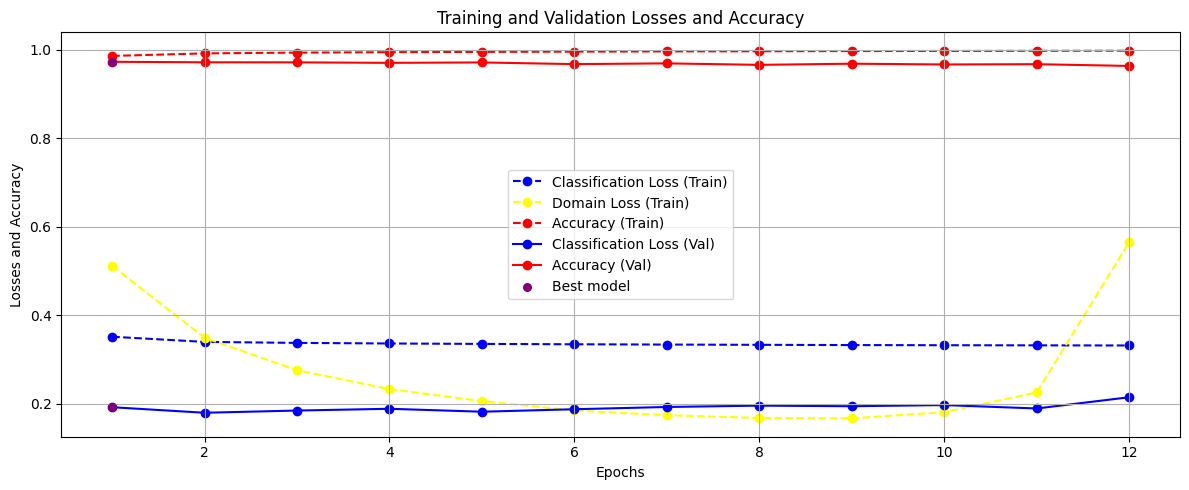

In [154]:
best_features_extractor = None
best_classifier = None
best_val_acc = 0
best_val_loss = 0
best_epoch = 0

training_class_losses = []
training_class_metric = []
training_domain_losses = []
training_epochs = []

validation_class_losses = []
validation_class_metric = []
validation_epochs = []

# Regular updates of λ (according Ganin et Lempitsky, 2015)
# λ = 2 / (1 + exp(-10 * p)) - 1, with p from 0 to 1

total_steps = EPOCHS * len(pretrain_loader)
global_step = 0

# Define the descriptor
train_desc = "TRAINING : {} / {} epochs - Classifier Loss : {:.4f} | Classifier Accuracy : {:.4f} | Domain Loss : {:.4f} "
val_desc = "VALIDATION : {} / {} epochs - Classifier Loss : {:.4f} | Classifier Accuracy : {:.4f} "

# Training loop
for epoch in range(EPOCHS):

    ## Training phase
    features_extractor.train()
    classifier.train()
    domain_classifier.train()

    class_loss = 0
    domain_loss = 0
    current_num_data = 0

    global_step += 1
    #Compute p to dynamically adapt λ
    p = global_step / total_steps
    lambda_grl = 2. / (1. + np.exp(-10 * p)) - 1
    # Update GRL λ
    domain_classifier[0].lambda_ = lambda_grl

    train_tqdm = tqdm(zip(source_loader,cycle(target_loader)), total = len(source_loader), unit='batch')

    # Loop over the source and target datasets
    for i, (source_batch, target_batch) in enumerate(train_tqdm):

        # Load source data
        imgs_source, labels_source, centers_source = source_batch[0].to(device), source_batch[1].squeeze().to(device), source_batch[2].to(device)

        # Load target data
        imgs_target, labels_target, centers_target = target_batch[0].to(device), target_batch[1].squeeze().to(device), target_batch[2].to(device)

        imgs = torch.cat((imgs_source, imgs_target), dim=0)
        centers = torch.cat((centers_source, centers_target), dim=0)
        centers_index = torch.tensor([center_to_index[int(c)] for c in centers], dtype=torch.long).to(device) # convert center to index

        ## Forward pass
        # Extract features from the images
        features = features_extractor(imgs)
        features_sources = features[:len(imgs_source)]

        # Compute domain and label classifier predictiosn
        # pred_classifier = classifier(features_sources, return_logits=True)
        pred_classifier = classifier(features_sources).squeeze()
        pred_domain = domain_classifier(features) # the domain classifier return logits

        ## Compute the losses
        # Compute the classification loss
        labels = labels_source * (1 - smooth_eps) + 0.5 * smooth_eps
        class_loss_ = classification_criterion(pred_classifier, labels.float()) # move to long when using CrossEntropy
        # Compute the domain loss
        domain_loss_ = domain_criterion(pred_domain, centers_index)
        # Compute the total loss
        loss = ALPHA * class_loss_ + (1 - ALPHA) * domain_loss_

        ## Backpropagation
        optimizer_f.zero_grad()
        optimizer_c.zero_grad()
        optimizer_d.zero_grad()

        loss.backward()

        optimizer_f.step()
        optimizer_c.step()
        optimizer_d.step()
        # Store the losses and
        class_loss += class_loss_.item()
        domain_loss += domain_loss_.item()
        current_num_data += len(labels_source)
        # Compute the accuracy
        # pred_labels = torch.argmax(pred_classifier, dim=1)
        pred_labels = (torch.sigmoid(pred_classifier) > 0.5).float()
        acc = metric(pred_labels, labels_source)

        train_tqdm.set_description(train_desc.format(epoch+1, EPOCHS, class_loss / current_num_data, metric.compute().item(), domain_loss / current_num_data))

    training_class_losses.append(class_loss / current_num_data)
    training_class_metric.append(metric.compute().item())
    training_domain_losses.append(domain_loss / current_num_data)
    training_epochs.append(epoch+1)
    metric.reset()

    # scheduler_c.step()

    # Saving the model for sleep compute
    torch.save(features_extractor.state_dict(), f'model/features_exctractor_{METHOD}.pth')
    torch.save(classifier.state_dict(), f'model/features_exctractor_{METHOD}.pth')

    # scheduler.step()

    ## Validation phase
    if (epoch + 1) % VAL_EPOCHS == 0:

        current_num_data = 0
        class_loss = 0

        features_extractor.eval()
        classifier.eval()
        domain_classifier.eval()

        val_tqdm = tqdm(preval_loader, unit='batch')

        for i, (imgs, labels, _) in enumerate(val_tqdm):

            imgs = imgs.to(device)
            labels = labels.squeeze().to(device)

            # Forward pass
            with torch.no_grad():
                # Extract features from the images
                features = features_extractor(imgs)

                # pred_classifier = classifier(features, return_logits=True)
                pred_classifier = classifier(features).squeeze()

                # Compute the losses
                class_loss_ = classification_criterion(pred_classifier, labels.float())

                # Compute the accuracy
                # pred_labels = torch.argmax(pred_classifier, dim=1)
                pred_labels = (torch.sigmoid(pred_classifier) > 0.5).float()
                acc = metric(pred_labels, labels)

            class_loss += class_loss_.item()
            current_num_data += len(labels)

            val_tqdm.set_description(val_desc.format((epoch+1)//VAL_EPOCHS, EPOCHS//VAL_EPOCHS, class_loss / current_num_data, metric.compute().item()))

        validation_class_losses.append(class_loss / current_num_data)
        validation_class_metric.append(metric.compute().item())
        validation_epochs.append(epoch+1)
        metric.reset()

        if validation_class_metric[-1] > best_val_acc:
            best_features_extractor = deepcopy(features_extractor)
            best_classifier = deepcopy(classifier)
            best_val_acc = validation_class_metric[-1]
            best_val_loss = validation_class_losses[-1]
            best_epoch = epoch +1
            print(f"Best model updated at epoch {epoch+1} with accuracy {best_val_acc:.4f} and loss {best_val_loss:.4f}")

            # Saving each best model for sleep compute
            torch.save(best_features_extractor.state_dict(), f'model/best_feature_extractor_{METHOD}.pth')
            torch.save(best_classifier.state_dict(), f'model/best_classifier_{METHOD}.pth')

    if epoch - (best_epoch-1) > PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break

if PLOT :

    plt.figure(figsize=(12, 5))

    # Plot Training
    plt.plot(training_epochs, training_class_losses, label='Classification Loss (Train)', color = 'blue', linestyle = '--', marker = 'o', zorder = 1)
    plt.plot(training_epochs, training_domain_losses, label='Domain Loss (Train)', color = 'yellow', linestyle = '--', marker = 'o', zorder = 1)
    plt.plot(training_epochs, training_class_metric, label='Accuracy (Train)', color = 'red', linestyle = '--', marker = 'o', zorder = 1)

    if len(validation_epochs) > 0:
        # Plot Validation
        plt.plot(validation_epochs, validation_class_losses, label='Classification Loss (Val)', color = 'blue', linestyle = '-', marker = 'o', zorder = 1)
        plt.plot(validation_epochs, validation_class_metric, label='Accuracy (Val)', color = 'red', linestyle = '-', marker = 'o', zorder = 1)
        plt.scatter(best_epoch, best_val_acc, label = 'Best model', color = 'purple', marker = 'o', s = 30, zorder = 3)
        plt.scatter(best_epoch, best_val_loss, color = 'purple', marker = 'o', s = 30, zorder = 3)

    plt.title('Training and Validation Losses and Accuracy')
    # plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Losses and Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"imgs/{METHOD}.png")

    plt.show()

In [158]:
STAIN = False
MODEL = 'best_owk_backbone_domain_adaptated'

# Loading our feature extractor
backbone = timm.create_model(
  model_name="hf-hub:1aurent/vit_base_patch16_224.owkin_pancancer",
  pretrained=True
)
backbone.eval().to(device)

features_extractor = nn.Sequential(
    nn.LayerNorm(768, eps = 1e-06, elementwise_affine=True),
    nn.Linear(768, 384),  nn.ReLU()
)

classifier = nn.Sequential(
    nn.Linear(384, 100),
    nn.Dropout(0.4),
    nn.ReLU(),
    nn.Linear(100, 1)
)

features_extractor.load_state_dict(torch.load("model/best_feature_extractor_owk_backbone_domain_adaptated.pth"))
classifier.load_state_dict(torch.load("model/best_classifier_owk_backbone_domain_adaptated.pth"))

features_extractor.eval().to(device)
classifier.eval().to(device)

# Forward pass on the test dataset
solutions_data = {'ID' : [], 'Pred' : []}
with h5py.File(TEST_IMAGES_PATH, 'r') as h5f:
    test_ids = list(h5f.keys())
    for test_id in tqdm(test_ids):
        img = torch.from_numpy(h5f[test_id]['img'][()]).float()
        if STAIN:
            img = stain_transform(img).unsqueeze(0).to(device)
        else:
            img = preprocessing(img).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = features_extractor(backbone(img))
            pred = classifier(pred).detach().cpu()
        solutions_data['ID'].append(int(test_id))
        solutions_data['Pred'].append(int(torch.sigmoid(pred).item() > 0.5))
solutions_data = pd.DataFrame(solutions_data).set_index('ID')
solutions_data.to_csv(f'prediction/{MODEL}.csv')

  0%|          | 0/85054 [00:00<?, ?it/s]